# CS4243 Project

1. Clement Ng
2. Kimberley Tay
3. Wayne Tan

## Scraping dataset

1. Images are scraped from google images, duckduckgo images, and unsplash.
2. They are then manually labelled by us.

In [54]:
#from scraper import main

#main()

## Image Preprocessing

In this step, we will be taking a look at
1. The dataset distribution
2. Normalising of dataset
3. Saving the dataset in a .pt extension for easily reproducible results

In [1]:
from PIL import Image
from torchvision import datasets, transforms
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import time, os, torch, shutil

### Checking sizes of images

A few things to note:
1. base_folder defines the folder in which all the images are in.
2. It is assumed that the images are in their respective folders based on their labels, with the folder name being the label, and all of them are in base_folder.

In [2]:
base_folder = './dataset-raw'
classes = os.listdir(base_folder)
classes = [int(i) for i in classes]
classes.sort()

In [3]:
def dataset_stats(classes):
    stats = []
    paths = []
    for class_ in classes:
        folder_path = f'{base_folder}/{class_}'
        files = os.listdir(folder_path)
        files.sort()
        for file in files:
            file_path = f'{folder_path}/{file}'
            im = Image.open(file_path)
            size = im.size
            stats.append(size + (min(class_, 11), ))
            paths.append(file_path)
    return np.array(stats), np.array(paths)

In [4]:
stats, paths = dataset_stats(classes)

<AxesSubplot:ylabel='Count'>

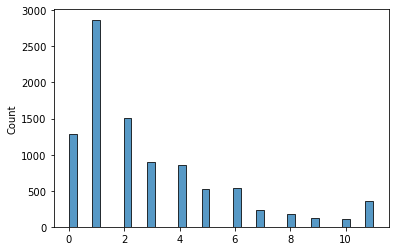

In [5]:
sns.histplot(x=stats[:, 2])

We observe that the amount of dataset for label 1 is much higher than the rest, so the measure we have chosen to adopt here is to deploy undersampling. Furthermore, for the labels >6, the quantity of dataset available is alot less than those <=6, and based on our decision that 6 is a good number to cut off. The label choice we have decided on will be [0, 1, 2, 3, 4, 5, 6, 7-10,>10].

We have determined that it doesnt make a difference whether there 11 or 12 people in an image, and 6 makes for a size suitable for a small group.

In [6]:
def get_ratio(stats):
    result = stats[:, 0:2].max(axis=1) / stats[:, 0:2].min(axis=1)
    return result

<AxesSubplot:ylabel='Count'>

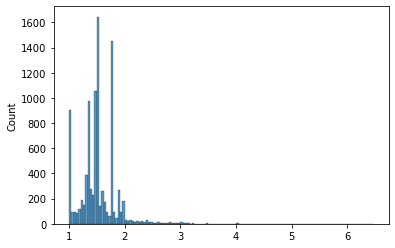

In [7]:
ratios = get_ratio(stats)
sns.histplot(x=ratios)

Most of the images lie within a boundary of 1 to 2 in aspect ratios, and since we decided to conduct undersampling for majority classes, we will prioritise keeping the images whose aspect ratio lie in this range. In other words, the images whose aspect ratios lie outside this range will be removed with priority.

In [25]:
size = len(stats)
train_proportion = 0.8
train_size = int(train_proportion*size)
np.random.seed(5)
shuffled_indices = np.random.permutation(np.arange(size))
train_indices = shuffled_indices[:train_size]
test_indices = shuffled_indices[train_size:]
train_set_stats = stats[train_indices]

In [11]:
print(np.median(train_set_stats, axis = 0))

[339. 249.   2.]


Since the smaller dimension of the median is 249 and we note that 224 x 224 is a common dimension for images resizing for CNN, we have chosen to adopt 224 x 224 as our dimension for images.

### Filtering Images

There are images which are very small compared to the size we have have chosen to keep, which is 224x224. So we will filter the images which are less than 1/4 of the desired size for all.

Furthermore, since there is a majority of dataset for label 0, 1 and 2, we have decided to undersample it, in the following order:
1. Selectively filter based on aspect ratio (so that the amount of black box in the dataset would not be too high.
2. Keep filtering until we have approximately equal to the number of datapoints as the next highest class.

In [12]:
def filter_small(stats, paths, size=256):
    crit_met = np.logical_and(
        stats[:, 0] >= size/2, stats[:, 1] >= size/2)
    return stats[crit_met], paths[crit_met]

In [13]:
stats[(stats[:,2] < 11) & (stats[:, 2] > 6), 2] = 7
stats[stats[:,2] >= 11, 2] = 8

From here on, label 7 will represent 7-10 people, and label 8 will denote > 10 people

(9475, 3)
(9233, 3) (9233,)


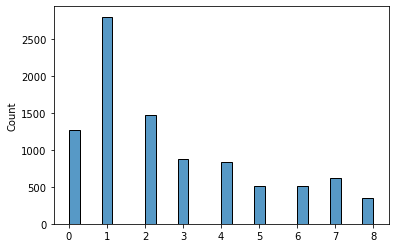

In [14]:
filtered_stats, filtered_paths = filter_small(stats, paths, 224)
sns.histplot(x=filtered_stats[:, 2])
print(stats.shape)
print(filtered_stats.shape, filtered_paths.shape)

In [15]:
def undersample(stats, paths):
    labels = np.unique(stats[:, 2])
    count = []
    for label in labels:
        count.append(np.count_nonzero(stats[:, 2] == label))
    count.sort()
    
    retain = count[-4]
    filtered = []
    filtered_paths = []
    for label in labels:
        
        # We scale the aspect ratios so that 1 -> 0, then 
        indices = (stats[:, 2] == label)
        stats_temp = stats[indices]
        paths_temp = paths[indices]
        
        ratio = np.abs(get_ratio(stats_temp) - 1)
        kept_indices = np.argsort(ratio)[: retain]
        filtered.append(stats_temp[kept_indices])
        filtered_paths.append(paths_temp[kept_indices])
    
    filtered = np.concatenate(filtered, axis=0)
    filtered_paths = np.concatenate(filtered_paths, axis=0)
    return filtered, filtered_paths

In [16]:
images, images_paths = undersample(filtered_stats, filtered_paths)

<AxesSubplot:ylabel='Count'>

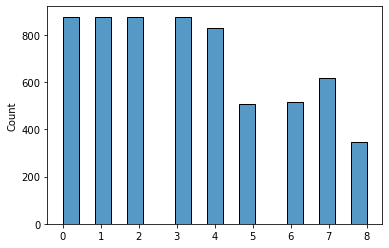

In [17]:
sns.histplot(x=images[:, 2])

### Normalising Size of images

1. We will be reading the images, converting them to the same size of 224x224, by scaling while retaining aspect ratio, then padding to a square with 0s.
2. If the original image is larger than 256 on either side, it will be scaled down, else the size will remain the same.
3. The dataset will then be saved to a .pt file, and uploaded to a repository so that it can be reproduced easier, instead of uploading all the images as a dataset.
4. This step will only be performed on a local computer with the dataset and does not need to be reproduced when reproducing the results.
5. If there are requests for the dataset used, please email XXX.

In [18]:
def make_square(im, size=256):
    x, y = im.size
    factor = x / y
    new_size = (size, size)
    if x < y:
        new_size = (int(factor*size), size)
    elif x > y:
        new_size = (size, int(size / factor))
    new_im = Image.new('RGB', (size, size), color=0)
    new_im.paste(im.resize(new_size),
                 (int((size - new_size[0]) / 2), int((size - new_size[1]) / 2)))
    return new_im

In [19]:
def load_dataset(entries, paths, size=256):
    transformer = transforms.ToTensor()
    dataset = []
    labels = []
    for entry, file_path in zip(entries, paths):
        label = entry[2]
        
        im = Image.open(file_path)
        new_im = make_square(im, size)
        
        dataset.append(transformer(new_im))
        labels.append(label)
        
    dataset = torch.stack(dataset, dim=0)
    labels = torch.tensor(labels)
    return dataset, labels

In [20]:
size = 224
dataset, labels = load_dataset(images, images_paths, size)

In [21]:
dataset.size()

torch.Size([6333, 3, 224, 224])

### Saving as a .pt file

The upload limit to github is 100mb per file, so we will save multiple instances.

In [26]:
total_size = dataset.size(0)
train_indices = train_indices[train_indices < total_size]
test_indices = test_indices[test_indices < total_size]

In [98]:
def save_data(dataset, name, indices):
    batch_size = 170
    total = indices.size
    for count in range(0, total, batch_size):
        batch_indices = indices[count: count+batch_size]
        batch = None
        if 'labels' in name:
            batch = dataset[batch_indices]
        elif 'data' in name:
            batch = dataset[batch_indices, :, :, :]
        
        if batch != None:
            torch.save(batch, 
                       f'./dataset/{name}/{name}_{(count//batch_size) + 1}.pt')
        else:
            print('Wrong name given')

In [99]:
save_data(dataset, 'train_data', train_indices)
save_data(labels, 'train_labels', train_indices)
save_data(dataset, 'test_data', test_indices)
save_data(labels, 'test_labels', test_indices)

## Training of the model

The main goals of this step is to
1. Perform a Vanilla CNN
2. Try to develop a more advanced structure mainly based on the hierarichal features idea taught in class

### Getting dataset

Using the requests module to download the dataset from our repo. (For use when running the notebook from collab where the files have yet to be downloaded)

In [1]:
import os, torch

In [4]:
files = {
    'train_data': [
        'https://github.com/ClementNgZiQian/CS4243_2122S2_Project/blob/main/dataset/train_data/train_data_1.pt?raw=true',
        30
    ],
    'train_labels': [
        'https://github.com/ClementNgZiQian/CS4243_2122S2_Project/blob/main/dataset/train_labels/train_labels_1.pt?raw=true',
        30
    ],
    'test_data': [
        'https://github.com/ClementNgZiQian/CS4243_2122S2_Project/blob/main/dataset/test_data/test_data_1.pt?raw=true',
        8
    ],
    'test_labels': [
        'https://github.com/ClementNgZiQian/CS4243_2122S2_Project/blob/main/dataset/test_labels/test_labels_1.pt?raw=true',
        8
    ],
}

In [5]:
import requests
base_folder = './dataset'

def check_dataset(files):
    for type_, info in files.items():
        if not os.path.exists(os.path.join(base_folder, type_)):
            os.makedirs(os.path.join(base_folder, type_))
        url = info[0]
        
        for i in range(info[-1]):
            name = f'{type_}_{i+1}'
            file_path = f'{base_folder}/{type_}/{name}.pt'
            if not os.path.exists(file_path):
                r = requests.get(url.replace(f'{type_}_1', name))
                with open(file_path, 'wb') as f:
                    f.write(r.content)

not_found = check_dataset(files)

In [6]:
def load_dataset(type_):
    folder = os.path.join(base_folder, type_)
    files = os.listdir(folder)
    files = [os.path.join(folder, i) for i in files]
    files.sort()
    result = torch.load(files[0])
    for file in files[1:]:
        result = torch.cat((result, torch.load(file)), dim=0)
    return result

In [38]:
train_data = load_dataset('train_data')
train_label = load_dataset('train_labels')
test_data = load_dataset('test_data')
test_label = load_dataset('test_labels')

### Helper functions for training model multiple times

In [8]:
def get_accuracy(scores, labels):
    bs = labels.size(0)
    predicted_labels = scores.argmax(dim=1)
    indicator = (predicted_labels == labels)
    num_error = indicator.sum()
    return num_error.float()/bs

In [16]:
def train_model(model, criterion, train_data, train_label, 
                device, epochs, normalize=True, bs=100, lr=0.1):
    
    #torch.autograd.set_detect_anomaly(True)
    start = time.time()
    train_size = train_data.size(0)
    num_batches = (train_size // bs) + 1
    losses = np.zeros([epochs])
    accuracies = np.zeros([epochs])
    
    mean = train_data.mean()
    mean = mean.to(device)
    std = train_data.std()
    std = std.to(device)
    
    for epoch in range(epochs):
        epoch_loss = 0
        epoch_accuracy = 0
        
        if epoch % 10 == 9:
            lr = lr / 2
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        shuffled_indices = torch.randperm(train_size)
        
        for count in range(0, train_size, bs):
            optimizer.zero_grad()
            
            indices = shuffled_indices[count: count+bs]
            minibatch_data = train_data[indices]
            minibatch_label = train_label[indices]
            
            minibatch_data = minibatch_data.to(device)
            minibatch_label = minibatch_label.to(device)
            
            if normalize:
                minibatch_data = (minibatch_data - mean) / std
            
            minibatch_data.requires_grad_()
            
            scores = model(minibatch_data)
            loss = criterion(scores, minibatch_label)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.detach().item()
            epoch_accuracy += get_accuracy(scores, minibatch_label).item()
        
        accuracies[epoch] = epoch_accuracy/num_batches
        
        losses[epoch] = epoch_loss/num_batches
        
        if epoch % 10 == 9:
            elapsed = time.time() - start
            print(f'Epoch = {epoch}, Time = {elapsed/60:.3f}min, \
              Loss={losses[epoch]:.3f}, Accuracy={accuracies[epoch]*100:.3f}%')
    
    return model, accuracies, losses

In [19]:
def test_model(model, test_data, test_label, 
               bs=100, normalize=True):
    
    accuracy = 0
    test_size = test_label.size(0)
    num_batches = (test_size // bs) + 1
    
    mean = train_data.mean()
    mean = mean.to(device)
    std = train_data.std()
    std = std.to(device)
    
    for count in range(0, test_size, bs):
        minibatch_data = test_data[count: count+bs]
        minibatch_label = test_label[count: count+bs]
        
        minibatch_data = minibatch_data.to(device)
        minibatch_label = minibatch_label.to(device)
        
        if normalize:
            minibatch_data = (minibatch_data - mean) / std
        
        scores = model(minibatch_data)
        accuracy += get_accuracy(scores, minibatch_label).item()
    
    accuracy = accuracy / num_batches
    return accuracy

In [25]:
def plot_accuracies(train_accuracy, test_accuracy):
    plt.plot(train_accuracy, label='Train Accuracy')
    plt.plot(test_accuracy * np.ones(train_accuracy.shape), label='Test Accuracy')
    plt.legend()
    plt.show()

In [47]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [48]:
def get_metrics(model, test_data, test_label, device):
    
    test_size = test_label.size(0)
    
    mean = test_data.mean()
    mean = mean.to(device)
    std = test_data.std()
    std = std.to(device)
    accuracy = 0
    precision = 0
    recall = 0
    f1 = 0
    
    inputs = test_data.to(device)
    test_label = test_label.to(device)
    inputs = (inputs - mean) / std
    scores = model(inputs)
        
    predicted_label = scores.argmax(dim=1).detach().numpy()
    test_labels = test_label.detach().numpy()
    
    accuracy += accuracy_score(predicted_label, test_label)
    precision += precision_score(predicted_label, test_label, average = 'weighted')
    recall += recall_score(predicted_label, test_label, average = 'weighted')
    f1 += f1_score(predicted_label, test_label, average = 'weighted')
    
    return accuracy, precision, recall, f1

### Vanilla CNN

We will begin with a simple CNN model, with 1 convolutional and linear layer each

In [12]:
import torch.nn as nn
import time
import numpy as np
from matplotlib import pyplot as plt

device = torch.device('cpu')

In [13]:
size = np.array([224, 224])

class Vanilla_CNN(nn.Module):
    
    def __init__(self, hidden_dim, output_dim):
        super(Vanilla_CNN, self).__init__()
        
        self.linear_dim = hidden_dim*size.prod()
        self.conv = nn.Conv2d(3, hidden_dim, kernel_size=3, padding=1)
        self.linear = nn.Linear(self.linear_dim, output_dim)
    
    def forward(self, x):
        # 3 x 224 x 224 -> hidden_dim x 224 x 224
        x = self.conv(x)
        x = torch.relu(x)
        # hidden_dim x 224 x 224 -> hidden_dim*224*224
        x = x.view(-1, self.linear_dim)
        # hidden_dim*224*224 -> 9
        x = self.linear(x)
        return x

In [14]:
van_net = Vanilla_CNN(16, 9)
van_net = van_net.to(device)
criterion = nn.CrossEntropyLoss()

In [17]:
van_net, train_accuracy, train_loss = \
    train_model(van_net, criterion, train_data, train_label, device, epochs=5)

In [20]:
test_accuracy = test_model(van_net, test_data, test_label)

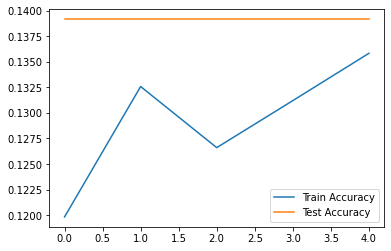

In [26]:
plot_accuracies(train_accuracy, test_accuracy)

### Simplification of the problem

After consulting out TA on why our test error is still high even though our training error was low, we were advised to simplify our problem into a 5-class classification where we classified images with at most 4 people.

In [43]:
mask_train = train_label <= 4
mask_test = test_label <= 4


train_label_2 = train_label[mask_train]
train_data_2 = train_data[mask_train]
test_label_2 = test_label[mask_test]
test_data_2 = test_data[mask_test]

In [45]:
print(train_data_2.shape)
print(test_data_2.shape)

torch.Size([3451, 3, 224, 224])
torch.Size([890, 3, 224, 224])


In [51]:
van_net = Vanilla_CNN(16, 5)
van_net = van_net.to(device)
criterion = nn.CrossEntropyLoss()

In [52]:
van_net, train_accuracy, train_loss = \
    train_model(van_net, criterion, train_data_2, train_label_2, device, epochs=2, lr=0.2)

In [53]:
test_accuracy = test_model(van_net, test_data_2, test_label_2)

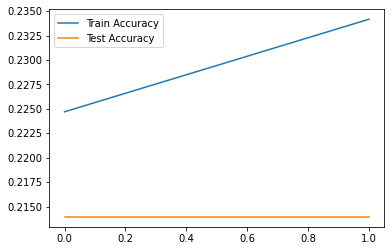

In [54]:
plot_accuracies(train_accuracy, test_accuracy)

In [ ]:
accuracy, precision, recall, f1 = get_metrics(van_net, test_data_2, test_label_2)

### Multi-column CNN (MCNN)

Observing that there was not much improvement in the performance of the model, we try a Multi-column CNN which should perform better than a vanilla CNN.

In [49]:
class MCNN(nn.Module):
    
    def __init__(self, hidden1, hidden2, hidden3, linear_dim, output_dim):
        super(MCNN, self).__init__()
        
        self.linear_dim = linear_dim
        
        self.linear = nn.Linear(self.linear_dim, output_dim)
        
        self.branch1 = nn.Sequential(nn.Conv2d(3, hidden1, kernel_size= 9, padding=4),
                                     nn.MaxPool2d(2),
                                     nn.Conv2d(hidden1, hidden1*2, kernel_size= 7, padding=3),
                                     nn.MaxPool2d(2),
                                     nn.Conv2d(hidden1*2, hidden1, kernel_size= 7, padding=3),
                                     nn.Conv2d(hidden1,  hidden1//2, kernel_size= 7, padding=3))
        
        self.branch2 = nn.Sequential(nn.Conv2d( 3, hidden2, kernel_size= 7, padding=3),
                                     nn.MaxPool2d(2),
                                     nn.Conv2d(hidden2, hidden2*2, kernel_size= 5 ,padding=2),
                                     nn.MaxPool2d(2),
                                     nn.Conv2d(hidden2*2, hidden2, kernel_size= 5 ,padding=2),
                                     nn.Conv2d(hidden2, hidden2//2, kernel_size= 5 ,padding=2))
        
        self.branch3 = nn.Sequential(nn.Conv2d( 3, hidden3, kernel_size= 5 ,padding=2),
                                     nn.MaxPool2d(2),
                                     nn.Conv2d(hidden3, hidden3*2, kernel_size= 3 ,padding=1),
                                     nn.MaxPool2d(2),
                                     nn.Conv2d(hidden3*2, hidden3, kernel_size= 3 ,padding=1),
                                     nn.Conv2d(hidden3, hidden3//2, kernel_size= 3 ,padding=1))
        
        self.fuse = nn.Sequential(nn.Conv2d(hidden1+hidden2+hidden3, 1, kernel_size= 1, padding=0))
        
    def forward(self, x):
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        x = torch.cat((x1,x2,x3), 1)
        x = self.fuse(x)
        x = torch.relu(x)
        x = x.view(-1, self.linear_dim)
        x = self.linear(x)
        return x


In [50]:
m_net = MCNN(9, 16, 20, 24, 56)
m_net = m_net.to(device)
criterion = nn.CrossEntropyLoss()

In [ ]:
m_net, train_accuracy, train_loss = \
    train_model(m_net, criterion, train_data_2, train_label_2, device, epochs=10, lr=0.2)

In [ ]:
test_accuracy = test_model(m_net, test_data_2, test_label_2)